In [72]:
'''
Package Imports
'''
import pandas as pd
import numpy as np
import pulp
from pulp import *
import datetime
import matplotlib.pyplot as plt

import FinOpsCodeDeck as finops

from IPython.display import Markdown as md
# %matplotlib widget

In [73]:
'''
Data Import for Current Term Structure
---
Imports all active treasury bonds data, time indexes them by year
'''

#NOT USED
#data_prompt = pd.read_excel('Table.xlsx', sheet_name='PromptUse', index_col = 'DateDue') #NOT USED
#data_prompt = data_prompt/1000 

term_structure_df = pd.read_excel('Table.xlsx', sheet_name='Bills Bonds and Notes')
term_structure_df['px_last'] = [i if i>=5 else 100 - i for i in term_structure_df['ASKED'].to_list()]
term_structure_df['ttm'] = [(i - datetime.datetime.now())/datetime.timedelta(days=365) for i in term_structure_df['MATURITY']]

In [74]:
'''
Bootstrap yield curve
---
begins with zero-coupon bonds to payout (ttm < 0.5 yrs) & calculates yield
moves to coupon bonds and uses calculated yields to bootstrap further
sorts all bonds into data frame indexed by ttm (by 100th of a year)
NOTE: Averages yields for the same time period
NOTE: assumes yield of period prior if yield for desired period does not exist
'''

'''short term rates'''
mats = []
round_to = 2
for bond_tenor in term_structure_df[term_structure_df['ttm'] <= 0.5].index:
    bond = term_structure_df.loc[bond_tenor]
    cpn = bond['COUPON']/2
    ttm = bond['ttm']
    px = bond['px_last']
    mats.append([np.round(ttm,round_to),np.log((100 + cpn) / bond['px_last']) / bond['ttm']])
rates = pd.DataFrame(mats, columns=['ttm','rate']).set_index('ttm').groupby('ttm').mean()

'''longer term rates'''
for bond_tenor in term_structure_df[term_structure_df['ttm']>=0.5].index:
    bond = term_structure_df.loc[bond_tenor]
    px = bond['px_last']
    ttm = bond['ttm']
    cpn = bond['COUPON']/2
    pmts = int(np.ceil(ttm * 2))
    cfs = [cpn if i+1<pmts else 100 + cpn for i in range(pmts)]
    cfs_idx = [np.round(ttm-i*0.5, round_to) for i in reversed(range(pmts))]
    known_rates = [rates[:cfs_idx[i]].iloc[-1,0] for i in range(pmts-1)]
    val = px - sum([cpn * np.exp((-1) * known_rates[i] * cfs_idx[i]) for i in range(pmts-1)])
    yld = (-1) * (np.log(val / (100+cpn)) / cfs_idx[pmts-1])
    add_df = pd.DataFrame([np.round(ttm, round_to), yld], index=['ttm','rate']).transpose().set_index('ttm')
    rates = pd.concat([rates,add_df],ignore_index=False)
    rates = rates.groupby('ttm').mean()

Text(0, 0.5, 'Yield in Percentage Points')

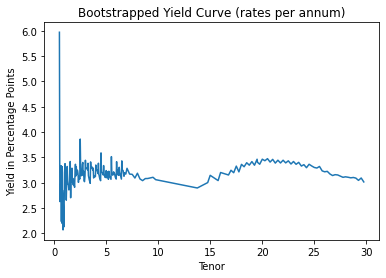

In [75]:
'''
plot yield curve
---
plots yield curve in percentage points
'''
plt.plot(rates[0.5:] * 100)
plt.title('Bootstrapped Yield Curve (rates per annum)')
plt.xlabel('Tenor')
plt.ylabel('Yield in Percentage Points')

In [76]:
data_prompt = pd.read_excel('Table.xlsx', sheet_name='PromptUse', index_col = 'DateDue')
data_prompt['ttm'] = np.round((data_prompt.index - datetime.datetime.now()) / datetime.timedelta(days=365), round_to)

r = []
for ttm in data_prompt['ttm']:
    r.append(rates[:ttm].iloc[-1,0])
data_prompt['rates'] = r

npv = sum([data_prompt.iloc[i,0]*np.exp((-1) * data_prompt.iloc[i,1] * data_prompt.iloc[i,2]) for i in range(len(data_prompt))])
dur = sum([data_prompt.iloc[i,1]*data_prompt.iloc[i,0]*np.exp((-1) * data_prompt.iloc[i,1] * data_prompt.iloc[i,2]) for i in range(len(data_prompt))])
con = sum([data_prompt.iloc[i,1]*(data_prompt.iloc[i,1]+1)*data_prompt.iloc[i,0]*np.exp((-1) * (data_prompt.iloc[i,1] + 2 ) * data_prompt.iloc[i,2]) for i in range(len(data_prompt))])

print('The Net Present Value of the Liabilities is ${:.2f} million dollars'.format(npv/1000))
print('The Macauley Duration of the Liability stream is {:.2f} years'.format(dur/npv))
print('The Convexity of the Liability stream is {:.2f}'.format(con/npv))

The Net Present Value of the Liabilities is $116.94 million dollars
The Macauley Duration of the Liability stream is 3.95 years
The Convexity of the Liability stream is 23.24


In [77]:
# Using markdown outputs instead of just printing

md('''
<center>

### Solutions

The Net Present Value of the Liabilities is $\${:.2f}$ MM

The Macauley Duration of the Liability stream is ${:.2f}$ years

The Convexity of the Liability stream is ${:.2f}$


'''.format(npv/1000,dur/npv,con/npv))



<center>

### Solutions

The Net Present Value of the Liabilities is $\$116.94$ MM

The Macauley Duration of the Liability stream is $3.95$ years

The Convexity of the Liability stream is $23.24$




In [78]:
ref_data = ['T ' + str(term_structure_df.iloc[bond,1]) + ' ' + term_structure_df.iloc[bond,0].strftime('%m/%d/%y') for bond in term_structure_df.index]
term_structure_df['ref_data'] = ref_data

bonds_clean = term_structure_df[['ref_data', 'px_last', 'ASKED YIELD']]
bonds_clean.columns = ['Bond', 'Price', 'Yield']
bonds_clean = bonds_clean.set_index('Bond')


In [79]:
bonds_clean

,Price,Yield
Bond,,
T 0.0 05/05/22,99.942,0.0580
T 0.0 05/10/22,99.925,0.0760
T 0.0 05/12/22,99.857,0.1450
T 1.75 05/15/22,100.024,-0.6005
T 2.125 05/15/22,100.030,-0.6944
...,...,...
T 1.875 02/15/51,76.280,3.0940
T 2.375 05/15/51,86.122,3.0890
T 2.0 08/15/51,79.076,3.0810


In [80]:
'''
Data Manipulation
'''
term_by_maturity = term_structure_df.set_index('MATURITY')
possibilities = term_by_maturity.drop(
    index=[i for i in term_by_maturity.index.to_list() if i > data_prompt.index.to_list()[-1]],
    columns=['BID', 'ASKED', 'CHG', 'ASKED YIELD']#, 'ttm']
    )

'''List of bond maturities less than liability maturity'''
date_lists_to_change_to_periods = [
    [i for i in possibilities.index.to_list() if i <= t]
    for t in data_prompt.index.tolist()
    ]
'''Removing the duplicates from each one'''
for i in reversed(range(1,len(date_lists_to_change_to_periods))):
    for j in range(0,len(date_lists_to_change_to_periods[i-1])):
        date_lists_to_change_to_periods[i].remove(date_lists_to_change_to_periods[i-1][j])

for i in range(0,len(date_lists_to_change_to_periods)):
    possibilities.loc[date_lists_to_change_to_periods[i],'period'] = i+1

possibilities['face'] = 100
possibilities['bond#'] = range(1,len(possibilities)+1)
possibilities = possibilities.set_index('bond#')

'''for labeling later'''
dec_var_names = possibilities['ref_data']

In [81]:
possibilities

,COUPON,px_last,ttm,ref_data,period,face
bond#,,,,,,
1,0.000,99.942,-0.023831,T 0.0 05/05/22,1.0,100
2,0.000,99.925,-0.010132,T 0.0 05/10/22,1.0,100
3,0.000,99.857,-0.004653,T 0.0 05/12/22,1.0,100
4,1.750,100.024,0.003567,T 1.75 05/15/22,1.0,100
5,2.125,100.030,0.003567,T 2.125 05/15/22,1.0,100
...,...,...,...,...,...,...
283,6.125,120.100,7.261101,T 6.125 08/15/29,15.0,100
284,1.750,91.182,7.513156,T 1.75 11/15/29,15.0,100
285,1.500,89.186,7.765210,T 1.5 02/15/30,16.0,100


In [82]:
'''Getting data ready for the solver'''

'''Empty Array'''
cfs = np.zeros((len(possibilities),len(date_lists_to_change_to_periods)))

'''CF Matrix'''
'''Will make function later'''
for i in range(0, len(cfs)):
    for j in range(1, len(cfs[0])+1):
        if possibilities.loc[i+1,'period'] == j and possibilities.loc[i+1,'COUPON'] == 0:
            cfs[i][j-1] = possibilities.loc[i+1,'face']
        elif possibilities.loc[i+1,'period'] == j and possibilities.loc[i+1,'COUPON'] != 0:
            cfs[i][0:j-1] = possibilities.loc[i+1,'COUPON']/2
            cfs[i][j-1] = possibilities.loc[i+1,'face'] + possibilities.loc[i+1,'COUPON']/2

cf_matrix = cfs.tolist()
prices = possibilities['px_last'].values.tolist()
liabilities = data_prompt['Amount'].values.tolist()

In [83]:
'''Solving for the dedicated portfolio'''

# Making variable list of strings
# bonds = ['$b_{}$'.format('{'+str(i)+'}') for i in range(1, len(cf_matrix)+1)]
periods = [i for i in range(0,len(cf_matrix[0])+1)]


#Removed Reverse (Not needed apparently?)
# Must reverse both price vector and cashflow matrix
#cf_matrix.reverse()
#prices.reverse()

# Dictionary of period constraints
period_dict = {}
for i in range(0,len(cf_matrix[0])):
    period_dict['Period {}'.format(i+1)] = dict(zip(dec_var_names,[cf_matrix[j][i] for j in range(0,len(cf_matrix))]))


objective = dict(zip(dec_var_names, prices))

# Decision Vars
quantity = LpVariable.dict('', dec_var_names, lowBound=0)
excess = LpVariable.dict('carryover', periods, lowBound=0)

# Intializing the Problem
dedication_1 = LpProblem('Dedicated', LpMinimize)

# Objective function
dedication_1 += excess[0]+lpSum([objective[i]*quantity[i] for i in dec_var_names])

# Constraints
for i in range(0,len(cf_matrix[0])):
    dedication_1 += lpSum([period_dict['Period {}'.format(i+1)][j]*quantity[j] for j in dec_var_names]) + excess[i]- excess[i+1] == liabilities[i]

dedication_1.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/rodrigopetricioli/Library/Python/3.9/lib/python/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/zl/vg5hkklj0c3gbf3hsqbpqp380000gn/T/0e463278dafb407e82ae8c209b32657a-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/zl/vg5hkklj0c3gbf3hsqbpqp380000gn/T/0e463278dafb407e82ae8c209b32657a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 21 COLUMNS
At line 1870 RHS
At line 1887 BOUNDS
At line 1888 ENDATA
Problem MODEL has 16 rows, 304 columns and 1560 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 16 (0) rows, 159 (-145) columns and 1100 (-460) elements
0  Obj 0 Primal inf 1290.1745 (16)
31  Obj 99826.174 Primal inf 213.71109 (3)
35  Obj 117327.8
Optimal - objective value 117327.8
After Postsolve, objective 117327.8, infeasibilities - dual 0 (0), primal 0 (0)
Optimal ob

1

In [84]:
solutions_1 = [v.varValue for v in dedication_1.variables()][0:len(dec_var_names)]

#Change Index - solver rearranges variables 
solution_df_1 = pd.DataFrame(solutions_1,index=dedication_1.variables()[:-len(excess)], columns= ['Quantity'])

#WRONG given that solver rearranges variables - prices don't match the bonds
#Also not needed  - solver gives the solution directly with dedication_1.objective.value()
#cost_each_1 = [solutions_1[i]*prices[i] for i in range(0,len(dec_var_names))]
#val_1 = sum(cost_each_1)/1000
val_1 = dedication_1.objective.value()/1000

#Add Excess CF to confrim they're 0
carries = [v.varValue for v in dedication_1.variables()][len(dec_var_names):(len(dec_var_names)+len(excess))]
carries_df = pd.DataFrame(carries, index = dedication_1.variables()[-len(excess):], columns=['Quantity'])


resultsss = solution_df_1[solution_df_1['Quantity']>0].append(carries_df)
# solution_df_1.drop(index = [i for i in bonds if solution_df_1.loc[i,'Quantity'] == 0], inplace=True)

In [85]:
solutions_1 = [{v, v.varValue} for v in dedication_1.variables()][0:len(dec_var_names)]
solutions_1

[{0.0, _T_0.0_01_26_23},
 {0.0, _T_0.0_02_23_23},
 {0.0, _T_0.0_03_23_23},
 {0.0, _T_0.0_04_20_23},
 {0.0, _T_0.0_05_05_22},
 {0.0, _T_0.0_05_10_22},
 {0.0, _T_0.0_05_12_22},
 {0.0, _T_0.0_05_17_22},
 {0.0, _T_0.0_05_19_22},
 {0.0, _T_0.0_05_24_22},
 {0.0, _T_0.0_05_26_22},
 {0.0, _T_0.0_05_31_22},
 {0.0, _T_0.0_06_02_22},
 {0.0, _T_0.0_06_07_22},
 {0.0, _T_0.0_06_09_22},
 {0.0, _T_0.0_06_14_22},
 {0.0, _T_0.0_06_16_22},
 {0.0, _T_0.0_06_21_22},
 {0.0, _T_0.0_06_23_22},
 {0.0, _T_0.0_06_28_22},
 {0.0, _T_0.0_06_30_22},
 {0.0, _T_0.0_07_07_22},
 {0.0, _T_0.0_07_14_22},
 {0.0, _T_0.0_07_21_22},
 {0.0, _T_0.0_07_28_22},
 {0.0, _T_0.0_08_04_22},
 {0.0, _T_0.0_08_11_22},
 {0.0, _T_0.0_08_18_22},
 {0.0, _T_0.0_08_25_22},
 {0.0, _T_0.0_09_01_22},
 {0.0, _T_0.0_09_08_22},
 {0.0, _T_0.0_09_15_22},
 {0.0, _T_0.0_09_22_22},
 {0.0, _T_0.0_09_29_22},
 {0.0, _T_0.0_10_06_22},
 {0.0, _T_0.0_10_13_22},
 {0.0, _T_0.0_10_20_22},
 {0.0, _T_0.0_10_27_22},
 {0.0, _T_0.0_11_03_22},
 {0.0, _T_0.0_12_01_22},


In [86]:
resultsss

,Quantity
_T_0.25_06_15_23,68.958621
_T_0.25_06_15_24,50.889969
_T_0.625_05_15_30,69.781931
_T_0.75_11_15_24,70.953582
_T_1.625_08_15_29,79.138928
_T_2.25_11_15_27,44.527815
_T_2.375_05_15_29,68.327538
_T_2.875_05_15_28,65.028752
_T_5.5_08_15_28,85.963541
_T_6.0_02_15_26,106.870780


In [87]:

# Just have to match bonds with the tickers Jack created instead

'''Printing Solutions'''

md(''' 
##### <center> Dedication Portfolio Cost & Composition  </center>

<center>

Portfolio Cost $ = \${:.2f} $ MM <br>

</center>

<center>

{}

'''.format(val_1,resultsss.to_markdown(colalign = ("right",))))

 
##### <center> Dedication Portfolio Cost & Composition  </center>

<center>

Portfolio Cost $ = \$117.33 $ MM <br>

</center>

<center>

|                   |   Quantity |
|------------------:|-----------:|
|  _T_0.25_06_15_23 |    68.9586 |
|  _T_0.25_06_15_24 |    50.89   |
| _T_0.625_05_15_30 |    69.7819 |
|  _T_0.75_11_15_24 |    70.9536 |
| _T_1.625_08_15_29 |    79.1389 |
|  _T_2.25_11_15_27 |    44.5278 |
| _T_2.375_05_15_29 |    68.3275 |
| _T_2.875_05_15_28 |    65.0288 |
|   _T_5.5_08_15_28 |    85.9635 |
|   _T_6.0_02_15_26 |   106.871  |
|  _T_6.25_08_15_23 |    59.0448 |
| _T_6.625_02_15_27 |    52.7795 |
|  _T_6.75_08_15_26 |    80.0769 |
| _T_6.875_08_15_25 |    74.3162 |
|  _T_7.25_08_15_22 |    85.8467 |
| _T_7.625_02_15_25 |    81.2197 |
|       carryover_0 |     0      |
|       carryover_1 |     0      |
|      carryover_10 |     0      |
|      carryover_11 |     0      |
|      carryover_12 |     0      |
|      carryover_13 |     0      |
|      carryover_14 |     0      |
|      carryover_15 |     0      |
|      carryover_16 |     0      |
|       carryover_2 |     0      |
|       carryover_3 |     0      |
|       carryover_4 |     0      |
|       carryover_5 |     0      |
|       carryover_6 |     0      |
|       carryover_7 |     0      |
|       carryover_8 |     0      |
|       carryover_9 |     0      |



In [88]:
'''
Pull sensitivity analysis
---
https://s3.amazonaws.com/assets.datacamp.com/production/course_8835/slides/chapter4.pdf
'''
o = [{'name':name, 'shadow price':c.pi} for name, c in dedication_1.constraints.items()]
shadow_px = pd.DataFrame(o).set_index(data_prompt.index).drop('name',axis=1)
clean_shadow_px = pd.DataFrame(o).set_index(data_prompt.index.strftime('%m/%d/%y')).drop('name',axis=1)
md(''' 
##### <center> Sensitivity Analysis - Shadow Prices  </center>

<center>

{}

'''.format(clean_shadow_px.to_markdown(colalign = ("right",)))
)

 
##### <center> Sensitivity Analysis - Shadow Prices  </center>

<center>

|   DateDue |   shadow price |
|----------:|---------------:|
|  12/15/22 |       0.977023 |
|  06/15/23 |       0.970186 |
|  12/15/23 |       0.95231  |
|  06/15/24 |       0.937843 |
|  12/15/24 |       0.924583 |
|  06/15/25 |       0.906067 |
|  12/15/25 |       0.895403 |
|  06/15/26 |       0.879163 |
|  12/15/26 |       0.862658 |
|  06/15/27 |       0.849548 |
|  12/15/27 |       0.840671 |
|  06/15/28 |       0.827461 |
|  12/15/28 |       0.812954 |
|  06/15/29 |       0.804787 |
|  12/15/29 |       0.795397 |
|  06/15/30 |       0.78642  |



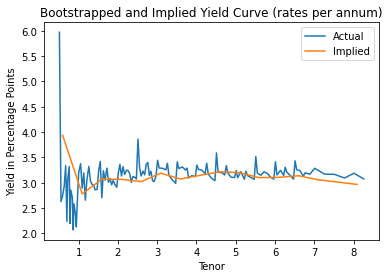

In [89]:
'''
Presents implied and actual yield curve as a plot
'''
shadow_ttm = ((shadow_px.index - datetime.datetime.now()) / datetime.timedelta(days=365)).to_list()
shadow_factors = shadow_px['shadow price'].to_list()
implied_rates = [-np.log(shadow_factors[i]) / shadow_ttm[i] for i in range(len(shadow_ttm))]

implied_rates_df = pd.DataFrame(
                        data = [shadow_ttm, implied_rates],
                        index=['ttm','implied_rate']
                    )

implied_rates_df = (implied_rates_df
                        .transpose()
                        .round({'ttm':round_to})
                        .set_index('ttm')
                    )

plt.plot(rates[0.5:8.5] * 100)
plt.plot(implied_rates_df * 100)
plt.title('Bootstrapped and Implied Yield Curve (rates per annum)')
plt.xlabel('Tenor')
plt.ylabel('Yield in Percentage Points')
plt.legend(['Actual', 'Implied'])

In [90]:
'''

'''

md(''' 
##### <center> Sensitivity Analysis - Shadow Prices  </center>

<center>

{}

'''.format((implied_rates_df*100).to_markdown(colalign = ("right",)))
)

 
##### <center> Sensitivity Analysis - Shadow Prices  </center>

<center>

|   ttm |   implied_rate |
|------:|---------------:|
|  0.59 |        3.94074 |
|  1.09 |        2.78066 |
|  1.59 |        3.0735  |
|  2.09 |        3.06863 |
|  2.59 |        3.02447 |
|  3.09 |        3.19102 |
|  3.59 |        3.07525 |
|  4.09 |        3.14783 |
|  4.59 |        3.21684 |
|  5.09 |        3.20258 |
|  5.59 |        3.10329 |
|  6.09 |        3.10788 |
|   6.6 |        3.13981 |
|  7.09 |        3.06143 |
|   7.6 |        3.01387 |
|  8.09 |        2.96844 |



In [91]:
possibilities

,COUPON,px_last,ttm,ref_data,period,face
bond#,,,,,,
1,0.000,99.942,-0.023831,T 0.0 05/05/22,1.0,100
2,0.000,99.925,-0.010132,T 0.0 05/10/22,1.0,100
3,0.000,99.857,-0.004653,T 0.0 05/12/22,1.0,100
4,1.750,100.024,0.003567,T 1.75 05/15/22,1.0,100
5,2.125,100.030,0.003567,T 2.125 05/15/22,1.0,100
...,...,...,...,...,...,...
283,6.125,120.100,7.261101,T 6.125 08/15/29,15.0,100
284,1.750,91.182,7.513156,T 1.75 11/15/29,15.0,100
285,1.500,89.186,7.765210,T 1.5 02/15/30,16.0,100


In [92]:
'''
Aggregates cashflow matrix and ref data for immunization
---
Puts cashflow matrix into a dataframe for merging
merges possible bond ref data with cashflow matrix
cleans resulting dataframe

NOTE: MATH NEEDS WORK HERE BUT WE CAN FIGURE OUT
from here: use ttm and col_num against calculated curve to find appropriate measure
        pv_factor = exp{-rt} = exp{- () * (ttm)}
'''

#Removed reveresed since i removed earlier
#cf_df = pd.DataFrame(cf_matrix, index=reversed(dec_var_names.to_list()))
cf_df = pd.DataFrame(cf_matrix, index=dec_var_names.to_list())

cf_df = pd.merge(                                                           # Combines possible bonds with cashflow matrix
    left = possibilities,                                                   # possible bonds - SAME DF AS DEDICATION
    right = cf_df,                                                          # Cashflow matrix - NP ARRAY FROM DEDICATION AS DF FOR MERGING
    how='inner',                                                            # Catches any missed bonds on merge
    left_on='ref_data',                                                     # possibilities not indexed by bond name - CHAZ IS THIS SOMETHING WE CAN ADJUST OR NO?????????????????????
    right_index=True                                                        # Casflow df indexed by bond name
)

cf_df = (cf_df
            .drop(['COUPON','period','face'],axis=1)                        # Drops unnecessary ref data
            .set_index('ref_data')                                          # Sets index to bond name
            .round({'ttm':round_to})                                        # rounds time to maturity to 2 decimal places -- allows use of derived term structure (indexed by hundredths)
        )

cf_df

,px_last,ttm,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
ref_data,,,,,,,,,,,,,,,,,,
T 0.0 05/05/22,99.942,-0.02,100.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
T 0.0 05/10/22,99.925,-0.01,100.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
T 0.0 05/12/22,99.857,-0.00,100.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
T 1.75 05/15/22,100.024,0.00,100.8750,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
T 2.125 05/15/22,100.030,0.00,101.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T 6.125 08/15/29,120.100,7.26,3.0625,3.0625,3.0625,3.0625,3.0625,3.0625,3.0625,3.0625,3.0625,3.0625,3.0625,3.0625,3.0625,3.0625,103.0625,0.0000
T 1.75 11/15/29,91.182,7.51,0.8750,0.8750,0.8750,0.8750,0.8750,0.8750,0.8750,0.8750,0.8750,0.8750,0.8750,0.8750,0.8750,0.8750,100.8750,0.0000
T 1.5 02/15/30,89.186,7.77,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,100.7500


In [93]:
'''
Create PResent Value, Duration, and Convexity factors for all possible time index based on derived rates curve
'''
t = rates.index
r = rates['rate']
npv_factor = np.exp(-r*t)
dur_factor = (t / (1+r)) * np.exp(-r*t)
con_factor = ((t*(t+1))/ (1+r)**2) * np.exp(-r*t)

In [94]:
'''
Calculates npv, duration, and convexity terms for all bonds consiuder in problem
'''
npvs=[]
durs=[]
cons=[]
for bond in cf_df.index:
    bond_df = cf_df.loc[bond]
    bond_ttm = bond_df.loc['ttm']
    bond_cf_stream = bond_df.loc[0:]
    eo_cfs = bond_cf_stream.idxmax()
    cpn_ttm = [(bond_ttm - 0.5*i).round(round_to) for i in range(eo_cfs+1)]
    bond_cf_ttm = pd.Series(data=bond_df.loc[0:eo_cfs].to_list(), index=reversed(cpn_ttm))

    bond_npv = sum([bond_cf_ttm.loc[i] * npv_factor.loc[:i].iloc[-1] for i in bond_cf_ttm.index])
    bond_dur = sum([bond_cf_ttm.loc[i] * dur_factor.loc[:i].iloc[-1] for i in bond_cf_ttm.index])
    bond_con = sum([bond_cf_ttm.loc[i] * con_factor.loc[:i].iloc[-1] for i in bond_cf_ttm.index])

    npvs.append(bond_npv)
    durs.append(bond_dur)
    cons.append(bond_con)

immunization_df = pd.DataFrame([npvs, durs, cons], columns=cf_df.index, index=['npv','duration','convexity']).transpose()

In [95]:
immunization_df

,npv,duration,convexity
ref_data,,,
T 0.0 05/05/22,99.951321,-2.048908,-2.058034
T 0.0 05/10/22,99.925977,-1.079173,-1.153822
T 0.0 05/12/22,100.000000,0.000000,0.000000
T 1.75 05/15/22,100.875000,0.000000,0.000000
T 2.125 05/15/22,101.062500,0.000000,0.000000
...,...,...,...
T 6.125 08/15/29,120.163437,701.297387,5287.990238
T 1.75 11/15/29,90.308883,616.661274,4984.821074
T 1.5 02/15/30,89.189168,631.910324,5278.227214


In [96]:
'''
Solves immunization portfolio
'''
bond_count = LpVariable.dicts('Bonds',dec_var_names,lowBound=0)

immunization = LpProblem('immunization', LpMinimize)

immunization += lpSum([cf_df['px_last'].loc[i] * bond_count[i] for i in dec_var_names])
immunization += lpSum([immunization_df['npv'].loc[i] * bond_count[i] for i in dec_var_names]) == npv
immunization += lpSum([immunization_df['duration'].loc[i] * bond_count[i] for i in dec_var_names]) == dur
immunization += lpSum([immunization_df['convexity'].loc[i] * bond_count[i] for i in dec_var_names]) == con

immunization.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/rodrigopetricioli/Library/Python/3.9/lib/python/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/zl/vg5hkklj0c3gbf3hsqbpqp380000gn/T/9f5213c46c394c1caece8fadfffb0a54-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/zl/vg5hkklj0c3gbf3hsqbpqp380000gn/T/9f5213c46c394c1caece8fadfffb0a54-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 8 COLUMNS
At line 1151 RHS
At line 1155 BOUNDS
At line 1156 ENDATA
Problem MODEL has 3 rows, 287 columns and 855 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 3 (0) rows, 280 (-7) columns and 838 (-17) elements
0  Obj 0 Primal inf 59780.453 (3)
17  Obj 116390.88
Optimal - objective value 116390.88
After Postsolve, objective 116390.88, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 116390.8766 - 17 iterations time 0.002, P

1

In [97]:
'''
Print Solution to Immunized portfolio
'''
bonds_fin = pd.DataFrame([[v.name[6:] for v in immunization.variables()], [v.varValue for v in immunization.variables()]], index=['bond','amt']).transpose().set_index('bond')
bonds_fin[bonds_fin['amt']>0]

md(''' 
##### <center> Portoflio Allocation - Immunization  </center>

<center> Immunized Portfolio Value of ${:.2f} MM  </center> <br>


<center>

{}

'''.format(value(immunization.objective) / 1000, bonds_fin[bonds_fin['amt']>0].to_markdown(colalign = ("right",)))
)

 
##### <center> Portoflio Allocation - Immunization  </center>

<center> Immunized Portfolio Value of $116.39 MM  </center> <br>


<center>

|             bond |     amt |
|-----------------:|--------:|
|   T_1.5_02_15_30 | 136.239 |
| T_6.625_02_15_27 | 801.875 |
|  T_7.25_08_15_22 | 116.55  |



## Problem 6

Combine a cash matching strategy (dedication) for the liabilities for the first three years and an immunization strategy based on matching present value, duration and convexity for the liabilities during the last five years. Compare the characteristics of the three bond portfolios you have obtained. Explain which one you think is the best one and why.

In [98]:
'''
Immunization part
Calculates npv, duration, and convexity terms for all bonds considered in the problem
FROM period 7-16
'''

ded_period = 6
imm_period = 5
imm_start_period = len(data_prompt) - imm_period*2
imm_end_period = len(data_prompt)

npvs2=[]
durs2=[]
cons2=[]
for bond in cf_df.index:
    bond_df = cf_df.loc[bond]
    bond_ttm = bond_df.loc['ttm']
    bond_cf_stream = bond_df.loc[imm_start_period:]
    eo_cfs = bond_cf_stream.idxmax()
    cpn_ttm = [(bond_ttm - 0.5*i).round(round_to) for i in range(eo_cfs+1-imm_start_period)]
    bond_cf_ttm = pd.Series(data=bond_df.loc[imm_start_period:eo_cfs].to_list(), index=reversed(cpn_ttm))

    bond_npv = sum([bond_cf_ttm.loc[i] * npv_factor.loc[:i].iloc[-1] for i in bond_cf_ttm.index])
    bond_dur = sum([bond_cf_ttm.loc[i] * dur_factor.loc[:i].iloc[-1] for i in bond_cf_ttm.index])
    bond_con = sum([bond_cf_ttm.loc[i] * con_factor.loc[:i].iloc[-1] for i in bond_cf_ttm.index])

    npvs2.append(bond_npv)
    durs2.append(bond_dur)
    cons2.append(bond_con)

immunization_df2 = pd.DataFrame([npvs2, durs2, cons2], columns=cf_df.index, index=['npv','duration','convexity']).transpose()

In [99]:
'''
Immunization part for Liabilities
Calculates npv, duration, and convexity of liabilities
FROM YEAR 1-3
'''



data_prompt2 = data_prompt
r2 = []
for ttm in data_prompt2['ttm']:
    r2.append(rates[:ttm].iloc[-1,0])
data_prompt2['rates'] = r2

npv2 = sum([data_prompt2.iloc[i,0]*np.exp((-1) * data_prompt2.iloc[i,1] * data_prompt2.iloc[i,2]) for i in range(imm_start_period, imm_end_period)])
dur2 = sum([data_prompt2.iloc[i,1]*data_prompt2.iloc[i,0]*np.exp((-1) * data_prompt2.iloc[i,1] * data_prompt2.iloc[i,2]) for i in range(imm_start_period, imm_end_period)])
con2 = sum([data_prompt2.iloc[i,1]*(data_prompt2.iloc[i,1]+1)*data_prompt2.iloc[i,0]*np.exp((-1) * (data_prompt2.iloc[i,1] + 2 ) * data_prompt2.iloc[i,2]) for i in range(imm_start_period, imm_end_period)])

print('The Net Present Value of the Liabilities is ${:.2f} million dollars'.format(npv2/1000))
print('The Macauley Duration of the Liability stream is {:.2f} years'.format(dur2/npv2))
print('The Convexity of the Liability stream is {:.2f}'.format(con2/npv2))


The Net Present Value of the Liabilities is $65.85 million dollars
The Macauley Duration of the Liability stream is 5.63 years
The Convexity of the Liability stream is 37.07


In [100]:
'''
Solves combined portfolio
'''
bond_q = LpVariable.dicts('Bond',dec_var_names,lowBound=0)
excess_cf = LpVariable.dicts('ExcessCf', periods[:ded_period+1], lowBound=0)


combined = LpProblem('Combined', LpMinimize)

combined += lpSum([cf_df['px_last'][i] * bond_q[i] for i in dec_var_names]+ excess_cf[0]) 

for i in range(0,ded_period):
    combined += lpSum([cf_df[i][j]*bond_q[j] for j in dec_var_names]) + excess_cf[i]- excess_cf[i+1] == liabilities[i]

combined += lpSum([immunization_df['npv'][i] * bond_q[i] for i in dec_var_names]) == npv
combined += lpSum([immunization_df['duration'][i] * bond_q[i] for i in dec_var_names]) == dur
combined += lpSum([immunization_df['convexity'][i] * bond_q[i] for i in dec_var_names]) == con

combined.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/rodrigopetricioli/Library/Python/3.9/lib/python/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/zl/vg5hkklj0c3gbf3hsqbpqp380000gn/T/826d63bb614e49229179a04b3632ccaf-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/zl/vg5hkklj0c3gbf3hsqbpqp380000gn/T/826d63bb614e49229179a04b3632ccaf-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 14 COLUMNS
At line 2277 RHS
At line 2287 BOUNDS
At line 2288 ENDATA
Problem MODEL has 9 rows, 294 columns and 1974 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 9 (0) rows, 288 (-6) columns and 1953 (-21) elements
0  Obj 0 Primal inf 98275.366 (9)
17  Obj 119146.63
Optimal - objective value 119146.63
After Postsolve, objective 119146.63, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 119146.6306 - 17 iterations time 0.002

1

In [101]:
'''
Print Solution to Combined portfolio
'''
bonds_comb = pd.DataFrame([[v.name[6:] for v in combined.variables()], [v.varValue for v in combined.variables()]], index=['bond','amt']).transpose().set_index('bond')
bonds_comb[bonds_comb['amt']>0]

md(''' 
##### <center> Portoflio Allocation - Combined  </center>

<center> Combined Portfolio Value of ${:.2f} MM  </center> <br>


<center>

{}

'''.format(value(combined.objective) / 1000, bonds_comb[bonds_comb['amt']>0].to_markdown(colalign = ("right",)))
)

 
##### <center> Portoflio Allocation - Combined  </center>

<center> Combined Portfolio Value of $119.15 MM  </center> <br>


<center>

|            bond |       amt |
|----------------:|----------:|
| _0.125_12_15_23 |   74.887  |
|  _0.25_06_15_23 |   84.7811 |
|  _0.25_06_15_24 |   64.9338 |
|  _0.75_01_31_28 |  712.27   |
|   _1.0_12_15_24 |   85.015  |
|  _1.25_04_30_28 |   82.7132 |
| _1.625_12_15_22 |   84.0426 |
| _2.875_05_31_25 |   95.4401 |
|            Cf_0 | 2005.56   |



## Problem 7

The municipality would like to make a second bid (find a different portfolio of bonds). What is your best dedicated portfolio of risk-free bonds you can create *if short sales are allowed*? Did you find arbitrage opportunities? Did you take into consideration the bid-ask spread of the bonds? How would you take them in consideration and what is the result? Did you set limits in the transaction amounts? Discuss the practical feasibility of your solutions.

In [117]:
structure_df = term_structure_df
structure_df['px_ask'] = [i if i>=5 else 100 - i for i in term_structure_df['ASKED'].to_list()]
structure_df['px_bid'] = [i if i>=5 else 100 - i for i in term_structure_df['BID'].to_list()]

structure_df = structure_df.set_index('MATURITY').drop(
    index=[i for i in term_by_maturity.index.to_list() if i > data_prompt.index.to_list()[-1]],
    columns=['BID', 'ASKED', 'CHG', 'ASKED YIELD', 'px_last']
    )

structure_df['bond#'] = range(1,len(structure_df)+1)
structure_df = structure_df.set_index('bond#')
structure_df



,COUPON,ttm,ref_data,px_ask,px_bid
bond#,,,,,
1,0.000,-0.023831,T 0.0 05/05/22,99.942,99.932
2,0.000,-0.010132,T 0.0 05/10/22,99.925,99.915
3,0.000,-0.004653,T 0.0 05/12/22,99.857,99.847
4,1.750,0.003567,T 1.75 05/15/22,100.024,100.020
5,2.125,0.003567,T 2.125 05/15/22,100.030,100.024
...,...,...,...,...,...
283,6.125,7.261101,T 6.125 08/15/29,120.100,120.090
284,1.750,7.513156,T 1.75 11/15/29,91.182,91.172
285,1.500,7.765210,T 1.5 02/15/30,89.186,89.176
